In [66]:
import os
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv2D, ReLU, BatchNormalization, Flatten,
    Dense, Reshape, Conv2DTranspose, Activation, Lambda
)
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

# Functions to create the autoencoder components
def build_encoder(input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim):
    encoder_input = Input(shape=input_shape, name="encoder_input")
    x = encoder_input
    for i, (filters, kernels, strides) in enumerate(zip(conv_filters, conv_kernels, conv_strides)):
        x = Conv2D(
            filters=filters,
            kernel_size=kernels,
            strides=strides,
            padding="same",
            name=f"encoder_conv_layer_{i + 1}"
        )(x)
        x = ReLU(name=f"encoder_relu_{i + 1}")(x)
        x = BatchNormalization(name=f"encoder_bn_{i + 1}")(x)

    shape_before_bottleneck = K.int_shape(x)[1:]
    x = Flatten()(x)
    mu = Dense(latent_space_dim, name="mu")(x)
    log_variance = Dense(latent_space_dim, name="log_variance")(x)

    def sample_point_from_normal_distribution(args):
        mu, log_variance = args
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_variance / 2) * epsilon

    encoder_output = Lambda(
        sample_point_from_normal_distribution,
        name="encoder_output"
    )([mu, log_variance])

    return Model(encoder_input, encoder_output, name="encoder"), shape_before_bottleneck, mu, log_variance


def build_decoder(
    latent_space_dim, shape_before_bottleneck, conv_filters, conv_kernels, conv_strides
):
    decoder_input = Input(shape=latent_space_dim, name="decoder_input")
    num_neurons = np.prod(shape_before_bottleneck)
    x = Dense(num_neurons, name="decoder_dense")(decoder_input)
    x = Reshape(shape_before_bottleneck)(x)

    for i, (filters, kernels, strides) in reversed(list(enumerate(zip(conv_filters, conv_kernels, conv_strides)))):
        x = Conv2DTranspose(
            filters=filters,
            kernel_size=kernels,
            strides=strides,
            padding="same"  # Ensure output shape consistency
        )(x)
        x = ReLU(name=f"decoder_relu_{i + 1}")(x)
        x = BatchNormalization(name=f"decoder_bn_{i + 1}")(x)

    # Adjust the last layer to produce the expected shape (256, 64, 1)
    decoder_output = Conv2DTranspose(
        filters=1,
        kernel_size=conv_kernels[0],  # Kernel size
        strides=(1, 1),  # Adjusted stride
        padding="same",  # Ensure same output shape
        name=f"decoder_conv_transpose_layer_{len(conv_filters)}"
    )(x)

    output_layer = Activation("sigmoid", name="sigmoid_layer")(decoder_output)

    return Model(decoder_input, output_layer, name="decoder")


def build_autoencoder(encoder, decoder):
    model_input = encoder.input
    model_output = decoder(encoder(model_input))
    return Model(model_input, model_output, name="autoencoder")


# Loss functions
def combined_loss(y_target, y_predicted, mu, log_variance, reconstruction_loss_weight):
    reconstruction_loss = K.mean(K.square(y_target - y_predicted), axis=[1, 2, 3])
    kl_loss = -0.5 * K.sum(1 + log_variance - K.square(mu) - K.exp(log_variance), axis=1)
    return reconstruction_loss_weight * reconstruction_loss + kl_loss

def save_autoencoder_weights(autoencoder, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    weights_path = os.path.join(folder, "weights.h5")
    autoencoder.save_weights(weights_path)

# Corrected function to load autoencoder
def load_autoencoder(autoencoder, folder):
    weights_path = os.path.join(folder, "weights.h5")
    autoencoder.load_weights(weights_path)

    return autoencoder


# Main execution
if __name__ == "__main__":
    input_shape = (256, 64, 1)
    conv_filters = (512, 256, 128, 64, 32)
    conv_kernels = (3, 3, 3, 3, 3)
    conv_strides = (2, 2, 2, 2, (2, 1))
    latent_space_dim = 128
    reconstruction_loss_weight = 1000000
    
    encoder, shape_before_bottleneck, mu, log_variance = build_encoder(
        input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim
    )
    
    decoder = build_decoder(
        latent_space_dim, shape_before_bottleneck, conv_filters, conv_kernels, conv_strides
    )
    
    autoencoder = build_autoencoder(encoder, decoder)
    
    optimizer = tf.keras.optimizers.legacy.Adam(0.0005)
    autoencoder.compile(
        optimizer=optimizer,
        loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, mu, log_variance, reconstruction_loss_weight),
        metrics=[MeanSquaredError()],
    )
    
    autoencoder.summary()
    encoder.summary()
    decoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 64, 1)]      0         
                                                                 
 encoder (Functional)        (None, 128)               1838688   
                                                                 
 decoder (Functional)        (None, 256, 64, 1)        1717601   
                                                                 
Total params: 3556289 (13.57 MB)
Trainable params: 3552321 (13.55 MB)
Non-trainable params: 3968 (15.50 KB)
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 256, 64, 1)]         0   

 DTranspose)                                                     
                                                                 
 decoder_relu_3 (ReLU)       (None, 64, 16, 128)       0         
                                                                 
 decoder_bn_3 (BatchNormali  (None, 64, 16, 128)       512       
 zation)                                                         
                                                                 
 conv2d_transpose_43 (Conv2  (None, 128, 32, 256)      295168    
 DTranspose)                                                     
                                                                 
 decoder_relu_2 (ReLU)       (None, 128, 32, 256)      0         
                                                                 
 decoder_bn_2 (BatchNormali  (None, 128, 32, 256)      1024      
 zation)                                                         
                                                                 
 conv2d_tr

In [67]:
autoencoder = load_autoencoder(autoencoder,'model')

OSError: Unable to synchronously open file (file signature not found)

In [68]:
import os
import numpy as np

directory_path = "spectrograms"

loaded_dict = {}

file_list = os.listdir(directory_path)

for file_name in file_list:
    if file_name.endswith('.npy'):  
        file_path = os.path.join(directory_path, file_name)  
        array = np.load(file_path)  
        array_with_new_axis = np.expand_dims(array, axis=-1)
        loaded_dict[file_name] = array_with_new_axis
        

In [26]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the optimizer and loss function
batch_size = 64

# Check your data generator to ensure it produces batches with the expected shape
def data_generator(data_dict, batch_size):
    keys = list(data_dict.keys())
    while True:
        np.random.shuffle(keys)  # Shuffle keys for randomness
        for i in range(0, len(keys), batch_size):
            key_batch = keys[i:i + batch_size]
            x_batch = np.array([data_dict[key] for key in key_batch])
            
            yield x_batch, x_batch  # Autoencoders expect same input and output

# Define callbacks
checkpoint = ModelCheckpoint(
    "best_autoencoder.keras",
    monitor="loss",
    save_best_only=True,
    mode="min",
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

# train_gen = data_generator(loaded_dict, batch_size)
# Train the autoencoder

keys = list(loaded_dict.keys())
train_d = np.array([loaded_dict[key] for key in keys])

history = autoencoder.fit(
    train_d,
    train_d,
    batch_size=64,
    epochs=3,
    shuffle=True
)


Train on 3000 samples
Epoch 1/3
3000/3000 [==============================] - 1080s 360ms/sample - loss: 30800.4724 - mean_squared_error: 0.0302
Epoch 2/3
3000/3000 [==============================] - 1052s 351ms/sample - loss: 11229.7112 - mean_squared_error: 0.0109
Epoch 3/3
3000/3000 [==============================] - 1058s 353ms/sample - loss: 8520.8021 - mean_squared_error: 0.0082


In [69]:
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import tensorflow as tf 

def inverse_normalize_spectrogram(normalized_spectrogram, min_val, max_val):
    return normalized_spectrogram * (max_val - min_val) + min_val

def reconstruct_audio(stft, output_path, min_val, max_val):
    stft = stft[:, :, 0]
    magnitude_db = inverse_normalize_spectrogram(stft, min_val, max_val)
    magnitude_linear = librosa.db_to_amplitude(magnitude_db)
    y_reconstructed = librosa.istft(magnitude_linear, hop_length=256)
    sf.write(output_path, y_reconstructed, 22050)
    
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y_reconstructed, n_fft=512, hop_length=256)), ref=np.max)
    librosa.display.specshow(D, sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Reconstructed Spectrogram')
    plt.tight_layout()
    plt.show()

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import os

# Function to reconstruct audio from a given encoder, decoder, and batch of images
def reconstruct(encoder, decoder, batch_of_images):
    latent_representations = encoder.predict(batch_of_images)
    reconstructed_images = decoder.predict(latent_representations)
    return reconstructed_images, latent_representations

# Generate a batch of images for reconstruction
n_reconstructions = 5
keys = list(loaded_dict.keys())  # Assuming 'loaded_dict' is previously defined
random_keys = np.random.choice(keys, n_reconstructions, replace=False)
batch_of_images = np.array([loaded_dict[key] for key in random_keys])

# Reconstruct the images
reconstructed_images, latent_representations = reconstruct(encoder, decoder, batch_of_images)

# Corrected: 'reconstructed_images' is already a numpy array
def compare_reconstructed(reconstructed_images, min_max_dict, random_keys):
    for i, image in enumerate(reconstructed_images):
        file_name = random_keys[i]
        base_file_name = os.path.splitext(file_name)[0]

        # Get min and max values from the dictionary
        min_val = min_max_dict[base_file_name]['min']
        max_val = min_max_dict[base_file_name]['max']

        # Reconstruct audio
        reconstruct_audio(image, f"reconstructed_{file_name}.wav", min_val, max_val)
        reconstruct_audio(loaded_dict[file_name], f"original_{file_name}.wav", min_val, max_val)

# Load min/max values
min_max_dict = np.load('min_max_values.npy', allow_pickle=True).item()

# Compare reconstructed images with the original ones
compare_reconstructed(reconstructed_images, min_max_dict, random_keys)


KeyboardInterrupt: 

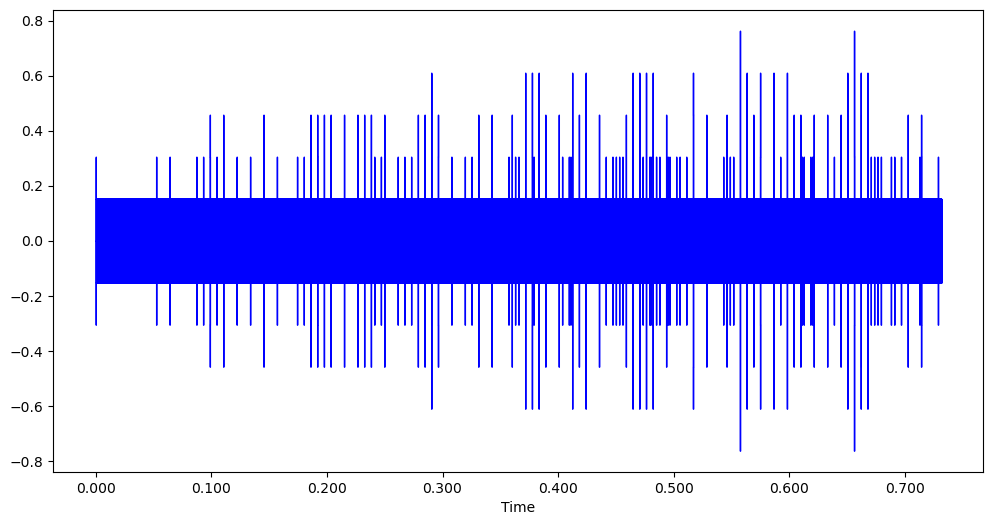

In [59]:
import librosa
import soundfile as sf
import numpy as np

# Load the audio file
audio_path = 'reconstructed_6_yweweler_30.npy.wav'
audio_data, sample_rate = librosa.load(audio_path, sr=None)

# Amplification factor (e.g., 1.5 to increase by 50%, 2.0 to double the amplitude)
amplification_factor = 5000
# Amplify the audio by scaling the amplitude
amplified_audio = audio_data * amplification_factor

# Ensure the amplified audio does not exceed the range [-1, 1] (clip if necessary)
amplified_audio = np.clip(amplified_audio, -1, 1)  # Prevent clipping/distortion

plt.figure(figsize=(12, 6))  # Set the figure size
librosa.display.waveshow(amplified_audio, sr=sample_rate, color='b') 

output_path = 'amplified_audio.wav'
sf.write(output_path, amplified_audio, sample_rate)

In [47]:
save_autoencoder(autoencoder, 'model')